In [160]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import tensorflow as tf
import h5py, os, yaml
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from tqdm import tqdm
import glob
import pandas as pd
import subprocess
import itertools
import tfr_evaluate, util
import explain
import embed
import metrics
import global_importance
from global_importance import GlobalImportance
from test_to_bw_fast import read_model, get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
# load and get model layer
run_path = '../'+'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01'
layer = -3
model, bin_size = read_model(run_path, compile_model=False)
aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
    

In [165]:
# load and threshold data
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)


In [9]:
cell_line = 13
threshold = 2
thresholded_C, thresholded_X, thresholded_Y = embed.threshold_cell_line_testset(testset, cell_line)
predictions = embed.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)
thresholded_Y.shape

In [167]:
low_C, low_X, low_Y = embed.threshold_cell_line_testset(testset, cell_line, more_than=1, less_than=2)
low_pred = embed.predict_np(low_X, model, batch_size=32, reshape_to_2D=False)
low_Y.shape

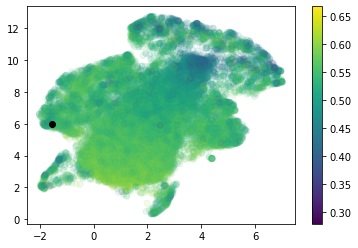

In [20]:
GC_content_all = get_GC_content(thresholded_X)
embeddings['GC content'] = GC_content_all

plt.scatter(x=embeddings['UMAP 1'], 
                y=embeddings['UMAP 2'],
                alpha=0.1,
                c=embeddings['GC content'],
               cmap='viridis_r')
plt.scatter(x=embeddings['UMAP 1'][2177], 
                y=embeddings['UMAP 2'][2177],c='k')

plt.clim(np.percentile(GC_content_all, 1),np.percentile(GC_content_all, 99))
c = plt.colorbar()
# plt.legend(bbox_to_anchor=(1,1));

In [250]:
# N, L, C = thresholded_Y.shape
# binned_Y = thresholded_Y.reshape(N, L//bin_size, bin_size, C).mean(axis=-2)
# mse = metrics.get_mse(binned_Y, 
#                       predictions).mean(axis=1).mean(axis=-1)
# pr = metrics.get_correlation_per_seq(binned_Y, 
#                       predictions, take_avg=False)        
# pr=np.array(pr).mean(axis=0)
# best_seqs = np.argwhere((mse<7) & (pr>0.89)).flatten()

# select sequences based on seamonster regions
# N = 1000
# top_N = np.argpartition(thresholded_Y.max(axis=1), -N)[-N:]
# left_N = np.argwhere(embed.select(embeddings, upper_lim_1=-1, lower_lim_2=5, idr='y')).flatten()
# left_idr_indx = left_N[np.argwhere((mse[left_N]<6) & (pr[left_N]>0.95)).flatten()]

In [271]:
motif_pattern = 'TGA.TCA'
alphabet='ACGT'
gi = GlobalImportance(model, alphabet)
gi.set_null_model('none', base_sequence=low_X, quant=True, num_sample=1000)  

In [76]:
# plt.plot(np.repeat((gi.embedded_predictions[:,:,1]).mean(axis=0), bin_size))
# plt.plot(np.repeat((gi.null_profiles[:,:,1]).mean(axis=0), bin_size))

In [191]:
%%time
kmer_size = 5
kmers = ["".join(p) for p in itertools.product(list(alphabet), repeat=kmer_size)]
all_motifs = []
all_scores = []

for kmer in tqdm(kmers):
    all_scores_per_motif = []
    motif_with_flanking_nucls = kmer[:2]+motif_pattern[:3]+kmer[2]+motif_pattern[4:]+kmer[3:]
    all_motifs.append(motif_with_flanking_nucls)
    diff_scores = gi.embed_predict_quant_effect([(motif_with_flanking_nucls, 1024)])
    all_scores_per_motif=(diff_scores).mean(axis=0).mean(axis=0)
    all_scores.append(all_scores_per_motif)

100%|██████████| 1024/1024 [45:32<00:00,  2.67s/it]

CPU times: user 19min 32s, sys: 2min 23s, total: 21min 56s
Wall time: 45min 32s


Text(0.5, 1.0, '# overlapping top 100 flanking motifs')

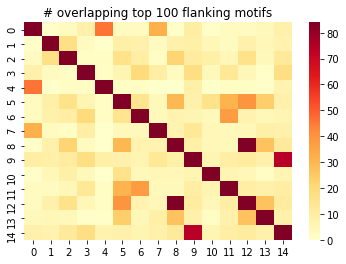

In [251]:
np_scores = np.array(all_scores)
top_N = 100
all_matches = []
for sort_by in range(15):
    l = []
    for c in range(15):
        l.append((np.sort([np_scores[:,c].argsort()[::-1][:top_N]]) == np.sort([np_scores[:,sort_by].argsort()[::-1][:top_N]])).sum())
    all_matches.append(l)

range_of_vals = np.sort(np.unique(np.array(all_matches).flatten()))
sns.heatmap(all_matches, vmin=range_of_vals[0], vmax = range_of_vals[-2], cmap='YlOrRd')
plt.title('# overlapping top 100 flanking motifs')

In [210]:
best_motif_and_flanking_nucls = all_motifs[np.argmax(np_scores[:,13])]
best_motif_and_flanking_nucls

'GATGACTCATA'

([<matplotlib.axis.XTick at 0x7f52882bcbe0>], [Text(0, 0, 'GATGACTCATA')])

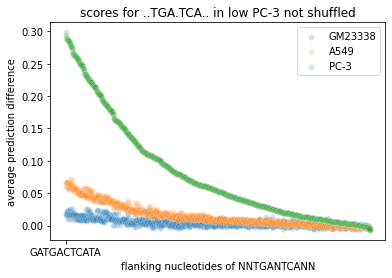

In [252]:
for c in [1,8,13]:
    sns.scatterplot(x=range(len(pc3_scores)), 
                    y=np_scores[:,c][pc3_scores.argsort()[::-1]], 
                    label=targets[c],
                    alpha=0.2
                   )
plt.xlabel('flanking nucleotides of NNTGANTCANN')
plt.ylabel('average prediction difference')
plt.title('scores for ..TGA.TCA.. in low PC-3 not shuffled')
plt.xticks([0], [best_motif_and_flanking_nucls])


In [123]:
%%time
all_positions = []
all_position_scores = []

for position in tqdm(range(0,2048-len(best_motif_and_flanking_nucls),2)):
    all_positions.append(position)
    diff_scores = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, position)])
    all_position_scores.append(((diff_scores).mean(axis=0)).mean(axis=0))

100%|██████████| 1019/1019 [46:08<00:00,  2.72s/it]

CPU times: user 18min 35s, sys: 4min 16s, total: 22min 52s
Wall time: 46min 8s


In [156]:
dfs = []
for i in range(15):
    df = pd.DataFrame({'position':all_positions, 
                    'delta prediction':np.array(all_position_scores)[:,i]})
    df['cell line'] = targets[i]
    dfs.append(df)

all_deltas = pd.concat(dfs)
center_only = all_deltas[(all_deltas['position']>200)&(all_deltas['position']<1900)]

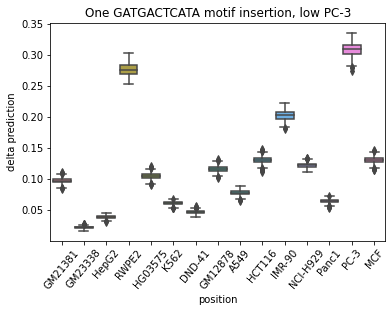

In [264]:
# for i in range(15):
best_motif_and_flanking_nucls = all_motifs[np.argmax(np_scores[:,13])]
sns.boxplot(data=center_only, x='cell line', y='delta prediction')
plt.title('One {} motif insertion, low PC-3'.format(best_motif_and_flanking_nucls))
plt.xlabel('position')
plt.ylabel('delta prediction')
# plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=50);

# position and multiplicity

In [116]:
all_position_scores_two = []
for position in tqdm(range(0,2048-len(best_motif_and_flanking_nucls),2)):
        diff_scores = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, 1024),
                                                     (best_motif_and_flanking_nucls, 
                                                      position)])
        all_position_scores_two.append((diff_scores[:,:,cell_line]).mean())


100%|██████████| 1019/1019 [45:59<00:00,  2.71s/it]


Text(0.5, 1.0, '2 instances of GATGACTCATA \n data=thresholded PC-3')

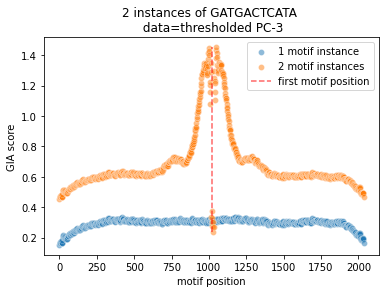

In [121]:
sns.scatterplot(x=all_positions, 
                y=all_position_scores, alpha=0.5, label='1 motif instance')

sns.scatterplot(x=range(0,len(all_position_scores_two)*2,2), 
                y=all_position_scores_two, alpha=0.5, label='2 motif instances')
plt.vlines(1024, np.min(all_position_scores_two), np.max(all_position_scores_two), 'r', 
           linestyle='--', alpha=0.6, label='first motif position')
plt.xlabel('motif position')
plt.ylabel('GIA score')

plt.legend()
plt.title('2 instances of {} \n data=thresholded {}'.format(best_motif_and_flanking_nucls, targets[cell_line]))

# do flanks matter?

In [353]:
gi = GlobalImportance(model, alphabet)
gi.set_null_model('none', base_sequence=low_X, quant=True, num_sample=1000, seed=42)  

seed set!


In [368]:
diff = gi.embed_predict_quant_effect([('TGA', 1024), 
                                      ('TCA', 1027)])
diff = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, 1022)])

In [ ]:
metrics.get_correlation_per_seq()

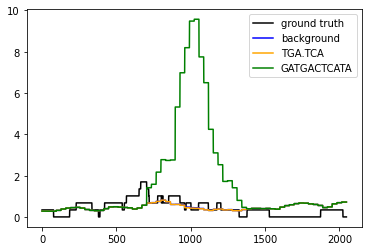

In [390]:
i = np.random.choice(1000)
plt.plot(low_Y[gi.null_sample_idx[i]], label='ground truth', c='k')
plt.plot(np.repeat(gi.null_profiles[:,:,cell_line][i], bin_size), 
         label='background', c='b')

plt.plot(np.repeat(gi.embedded_predictions['TGA at 1024 & TCA at 1027'][i,:,cell_line], bin_size),
        label='TGA.TCA', c='orange')
plt.plot(np.repeat(gi.embedded_predictions['GATGACTCATA at 1022'][i,:,cell_line], bin_size),
        label=best_motif_and_flanking_nucls, c='g')
plt.legend()

In [381]:
flank_dfs = [pd.DataFrame({'mean coverage':gi.null_profiles[:,:,cell_line].mean(axis=1),
                'motif':'background'})]
cell_line = 13

label_dict = {'TGA at 1024 & TCA at 1027':'TGA.TCA', 'GATGACTCATA at 1022':best_motif_and_flanking_nucls}

for l in gi.embedded_predictions.keys():
    flank_dfs.append(pd.DataFrame({'mean coverage':gi.embedded_predictions[l][:,:,cell_line].mean(axis=1),
    'motif':label_dict[l]}))
    print(l)
flank_dfs = pd.concat(flank_dfs)

TGA at 1024 & TCA at 1027
GATGACTCATA at 1022


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

background vs. TGA.TCA: Custom statistical test, P_val:7.790e-01
background vs. GATGACTCATA: Custom statistical test, P_val:5.623e-79


Text(0.5, 1.0, 'PC-3, low background')

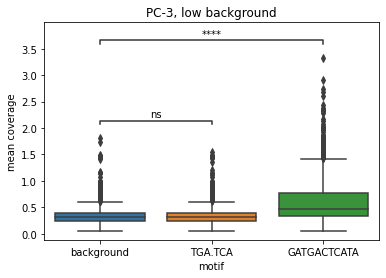

In [382]:
global_importance.boxplot_with_test(data=flank_dfs, 
                                    x='motif', 
                                    y='mean coverage', 
                                    pairs=[('GATGACTCATA', 'background'),('TGA.TCA', 'background')])
plt.title('PC-3, low background')

# do ATAAA and TGA.TCA interact?


First, choose flanking nucleotides for ATAAA

In [ ]:
%%time
kmer_size = 6
kmers = ["".join(p) for p in itertools.product(list(alphabet), repeat=kmer_size)]
all_motifs = []
all_scores = []
motif_pattern = 'ATAAA'
for kmer in tqdm(kmers):
    all_scores_per_motif = []
    motif_with_flanking_nucls = kmer[:3]+motif_pattern+kmer[3:]
    all_motifs.append(motif_with_flanking_nucls)
    diff_scores = gi.embed_predict_quant_effect([(motif_with_flanking_nucls, 1024)])
    all_scores_per_motif=(diff_scores).mean(axis=0).mean(axis=0)
    all_scores.append(all_scores_per_motif)

 17%|█▋        | 716/4096 [32:11<2:32:44,  2.71s/it]

In [391]:
gi = GlobalImportance(model, alphabet)
gi.set_null_model('none', base_sequence=low_X, quant=True, num_sample=1000, seed=42) 

seed set!


In [ ]:
diff = gi.embed_predict_quant_effect([('TGA', 1024), 
                                      ('TCA', 1027)])
diff = gi.embed_predict_quant_effect([(best_motif_and_flanking_nucls, 1022)])